<h1 style="text-align:center;">
Control of an Inverted Pendulum on a Cart
</h1>

<p style="text-align:center;">
CS3333 Industrial Instrumentation and Control
</p>

<p style="text-align:center;">
Deptartment of Computer Science and Engineering, University of Moratuwa
</p>

## 0. Prerequisites

This project uses `uv` for dependency management. If you haven't installed `uv` yet, you can do so by following these instructions: https://docs.astral.sh/uv/getting-started/installation/

And then run this in your terminal, in the root directory:

```bash
uv sync
```

This will automatically do several things:
1. Create a virtual environment
2. Download dependancies
3. Activate the virtual environment

Going forward, I recommend using this in your Python projects.


## 1. Setup

To start, we’ll install gym and then play with the cartpole system to get a feel for it.

You can find the documentation for the system [here](https://gymnasium.farama.org/environments/classic_control/cart_pole/), but it is not as useful as the  [Python source file](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py) for the cartpole system.

In [1]:
import gymnasium as gym
from gymnasium.utils.play import play
import math

Matplotlib is building the font cache; this may take a moment.


In [2]:
keys = {"a": 0, "d": 1}  # map keys 'a' and 'd' to actions left and right.
env = gym.make("CartPole-v1", render_mode="rgb_array_list")

play(env, keys_to_action=keys, noop=0)

You should now be able to control the cart with your keyboard. Use `a` to move the cart left, and `d` to move right. You should see something like this: 

![](assets/fast-reset.webp)

Notice that the default behaviour of Gymnasium is to reset the episode after the pole gets to only a 12 degree angle. This makes it a bit tough to play. Set the angle to 90 degrees by running the following and notice the difference.

In [3]:
keys = {"a": 0, "d": 1}  # map keys 'a' and 'd' to actions left and right.
env = gym.make("CartPole-v1", render_mode="rgb_array")

# this is the line that sets the 90-degree threshold
env.set_wrapper_attr("theta_threshold_radians", 90 * 2 * math.pi / 360)

play(env, keys_to_action=keys, noop=0)

## 2. Building a simple controller

Before we build a PID controller, let’s just try something simple and see if it works. 

We will go from manually controlling the cart to using a controller to do so.

Now, the observations we get from the environment are 4-dimensional. We get the cart position, cart velocity, pole angle, and pole angular velocity. A simple thing to try is to keep the cart in the center by moving right when position is negative, and left when it’s positive. We can express this in code as follows:

In [4]:
def controller(observation):
    cart_position, cart_velocity, pole_angle, pole_angular_velocity = observation
    action = 1 if cart_position < 0 else 0
    return action

In [7]:
# RUN ME WITH DIFFERENT CONTROLLERS

env = gym.make("CartPole-v1", render_mode="human", max_episode_steps=10000)
env.set_wrapper_attr("theta_threshold_radians", 90 * 2 * math.pi / 360)

observation, info = env.reset()
while True:
    try:
        # we call our simple controller to determine the action to perform
        action = controller(observation)

        # we run the system with the action
        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            observation, info = env.reset()

    except KeyboardInterrupt:
        break

env.close()

This doesn’t really work, but it’s as good as I am:

![](assets/simple-cart.webp)


What if instead we try keeping the pole upright instead of keeping the cart in the center? Change the action to reflect this:

In [6]:
def controller(observation):
    cart_position, cart_velocity, pole_angle, pole_angular_velocity = observation
    action = 1 if pole_angle > 0 else 0
    return action

And run the environment above with this new controller. It behaves a little better…


![](assets/simple-pole.webp)

… but still doesn’t quite solve the problem.

## 3. Proportional Derivative (PD) Control

What we made in the last section was actually a proportional controller, although it may not have looked like one. Let’s see what this means now.

Our “goal state” for the pole angle is 0, meaning the pole is balanced upright. A proportional controller applies a force to the cart which is _proportional_ to the error: the difference between the goal state and the measured observation.

```
error = goal - pole_angle
```

This error is multiplied by a constant $k_p$ to get the final control output.


```
output = kp * error
```

However, since the action space of gymnasium’s cart-pole system is discrete, we can only choose to apply a _fixed_ force either left or right. In the end, this amounts to simply taking the _sign_ of `output`, which is exactly what we did in the previous section.

To make a better controller, we’re also going to have to add a _derivative_ term to `output`.

Take another look at the behaviour of the controller above.

![](assets/simple-pole.webp)




We can see that it starts off OK, but then starts oscillating out of control. We need something to “dampen” these oscillations, and this is exactly what the “derivative” term of a PID controller does. This is really beautifully explained [here](https://youtu.be/fWQWX9-8_sA?t=1488).

Our new `output` is going to be a weighted sum of error and the derivative of the error $k_p⋅e+ k_p⋅e'$
:

    output = kp * error + kd * d_error

**Note that d_error can be computed completely numerically!** You can just compute `d_error` using the previous value of the error:

    d_error = last_error - error

Here, `last_error` was the value of `error` at the previous timestep, so this approximates the _rate of change of the error_. To make this a bit clearer, let’s write the whole process down in code.

**Note also that I’ve given some values of $k_p$ and $k_d$ that work well enough, but actually finding these constants is a science in itself, that we only breifly touch in this lab!**

## 4. Implementation of a PD Controller

First, let’s create a proportional-derivative controller as described above.


We construct the controller with constants constants $k_p$, $k_d$, and a desired goal state. Then in each time step of the simulation, we will call the `get_output()` function. This computes two things:

- `error`, the distance between the goal and our observation
- `delta_error`, the difference between current and previous error

where the latter approximates the “rate of change” of the error. Finally, we save the error value, and return the control output corresponding to the expression $k_p⋅e+k_d⋅e'$.

In [8]:
class PD:
    def __init__(self, kp: float, kd: float, delta_t: float, goal: float):
        self._kp = kp
        self._kd = kd
        self._dt = delta_t

        self._goal = goal

        self._integral = 0.0
        self._last_error = 0.0

    def get_output(self, measurement: float, log: bool = False) -> float:
        error = self._goal - measurement

        # calculate the Proportional Term (P)
        p_term = self._kp * error


        # calculate Derivative Term (D)
        # a derivative is simply the rate of change of the error!!!
        delta_error = error - self._last_error
        d_term = (
            (self._kd * (delta_error / self._dt)) if self._dt > 0 else 0.0
        )  # avoid division by zero

        # caculate the output
        output = p_term  + d_term

        if (log):
            print(
                f"output: {output}, p_term: {p_term}, d_term: {d_term}"
            )

        # save state
        self._last_error = error

        return output


We can use this simple controller in a script as follows:

In [9]:

env = gym.make("CartPole-v1", render_mode="human", max_episode_steps=10000)
dt = env.get_wrapper_attr("tau")

env.set_wrapper_attr("theta_threshold_radians", 90 * 2 * math.pi / 360)

# observing the pole angle for now
pole_controller = PD(kp=1.0, kd=1.0, delta_t=dt, goal=0.0)

observation, info = env.reset()

while True:
    try:
        pole_angle = observation[2]

        # get the control output
        pole_output = pole_controller.get_output(pole_angle)
        control_output = pole_output 
        # print(control_output)

        # get the overall output and convert it into an action
        action = 1 if control_output < 0 else 0

        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            observation, info = env.reset()

    except KeyboardInterrupt:
        break

env.close()


Below is the controller in action. 


![](assets/drift.webp)

This is pretty good: the pole is balanced, and the oscillations are gone.

However, we still have a problem: we aren’t trying to keep the cart in the center, and so it can start to drift away.

Let's add another controller that will monitor the **position** of the cart and guide the cart towards the center.

## 5. Two PD Controllers

We’ll fix this drift issue by including a second PD controller for the cart’s position, and then just summing the control outputs. 

In [10]:

env = gym.make("CartPole-v1", render_mode="human", max_episode_steps=10000)
env.set_wrapper_attr("theta_threshold_radians", 90 * 2 * math.pi / 360)
dt = env.get_wrapper_attr("tau")


# observing both the pole angle AND the cart position
cart_controller = PD(kp=0.2, kd=0.2, delta_t=dt, goal=0.0)
pole_controller = PD(kp=10.0, kd=1.0, delta_t=dt, goal=0.0)

observation, info = env.reset()

while True:
    try:
        cart_position = observation[0]
        pole_angle = observation[2]

        # get the control output by summing both controllers
        cart_output = cart_controller.get_output(cart_position)
        pole_output = pole_controller.get_output(pole_angle)
        control_output = cart_output + pole_output
        # print(control_output)

        # get the overall output and convert it into an action
        action = 1 if control_output < 0 else 0

        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            print(f"terminated {terminated}, truncated: {truncated}")
            observation, info = env.reset()

    except KeyboardInterrupt:
        break

env.close()




That gets us to our final controller, whose behaviour looks like this…

![](assets/controller.webp)

… and we’re _technically_ done. 

We are left with a working PD controller for the cart-pole system. The system keeps the pole vertical, while also keeping the cart centered. 


But here's the catch: It responds effectively to the **error right now** (Proportional term) and where the **error seems to be heading** (Derivative term based on the current trend). What it doesn't do is consider the **history of the error** – how much error has built up previously.

Think of it like this:
- P looks at the present.
- D looks towards the future (based on the current rate of change).
- There's no component looking back to correct for the sum of errors that occurred in the past.



## 6. The PID Controller

To make a better controller, we often need to add _derivative_ and _integral_ terms, creating a full PID (Proportional-Integral-Derivative) controller. Because sometimes a controller might settle with a small, persistent error (a "steady-state error"), perhaps because a constant force is needed to counteract gravity or friction, but the P term alone isn't enough without some error. The **Integral (I)** term addresses this. It accumulates the error over time. If there's a persistent error, this accumulated value grows, increasing the control output until the error is eliminated.

Our new `output` is going to be a weighted sum of the error (P), the integral of the error (I), and the derivative of the error (D):

$output = k_p \cdot error + k_i \cdot \int error \, dt + k_d \cdot \frac{d error}{dt}$

Numerically, we approximate these terms at each timestep:

*   **Proportional Term:** $k_p \cdot error$ (as before)
*   **Integral Term:** $k_i \cdot i\_error$ (where `i_error` is the accumulated sum of errors)
*   **Derivative Term:** $k_d \cdot d\_error$ (where `d_error` approximates the rate of change)

So the combined output is:

```
output = kp * error + ki * i_error + kd * d_error
```

**Note that both `i_error` and `d_error` can be computed numerically!**

You need to keep track of the error from the previous timestep (`last_error`) and maintain a running sum of the error (`i_error`, initialized to 0):

Here, `i_error` sums the error over time (approximating the integral), and `d_error` uses the change between the current and previous error to approximate the rate of change (derivative). The final `output` is then used (potentially just its sign) to determine the action (left/right force).


## 7. An implementation of a PID Controller


In [1]:
class PID:
    def __init__(self, kp: float, ki: float, kd: float, dt: float, goal: float):
        self._kp = kp
        self._ki = ki
        self._kd = kd
        self._dt = dt

        self._goal = goal

        self._i_error = 0.0
        self._last_error = 0.0

    def get_output(self, measurement: float, log: bool = False) -> float:
        error = self._goal - measurement

        # calculate the Proportional Term (P)
        p_term = self._kp * error

        # calculate Integral Term (I)
        # an integral is simply the sum of the error over time!!!
        self._i_error += error * self._dt
        i_term = self._ki * self._i_error

        # calculate Derivative Term (D)
        # a derivative is simply the rate of change of the error!!!
        d_error = error - self._last_error
        d_term = (
            (self._kd * (d_error / self._dt)) if self._dt > 0 else 0.0
        )  # avoid division by zero

        # caculate the output
        output = p_term + i_term + d_term

        if log:
            print(
                f"output: {output}, p_term: {p_term}, i_term: {i_term}, d_term: {d_term}"
            )

        # save state
        self._last_error = error

        return output

We can use our ✨fancy✨ new PID controller with the following code:

In [12]:
import gymnasium as gym
import math


env = gym.make("CartPole-v1", render_mode="human", max_episode_steps=10000)
delta_t = env.get_wrapper_attr("tau")
env.set_wrapper_attr("theta_threshold_radians", 90 * 2 * math.pi / 360)

cart_controller = PID(kp=1.0, ki=1.0, kd=2.0, dt=delta_t, goal=0.0)
pole_controller = PID(kp=9.0, ki=1.0, kd=5.0, dt=delta_t, goal=0.0)


observation, info = env.reset()

while True:
    try:
        cart_position = observation[0]
        pole_angle = observation[2]

        # get the control output by summing both controllers
        cart_output = cart_controller.get_output(cart_position)
        pole_output = pole_controller.get_output(pole_angle)
        control_output = 0.1 * cart_output + pole_output
        # print(control_output)

        # get the overall output and convert it into an action
        action = 1 if control_output < 0 else 0

        # run the system with the action as an input
        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            print(f"terminated {terminated}, truncated: {truncated}")
            observation, info = env.reset()

    except KeyboardInterrupt:
        break

env.close()

In this particular case, we don't see much improvement in terms of the system's stability or response. But PID controllers are by far the most common type of controller used in industry. They're simple, reliable, explainable and very easy to modify.

## 8. Exercise: Tuning a PID controller

The following section is some example code to start you off in the lab exercise for this tutorial. Please refer to the handout for more details.

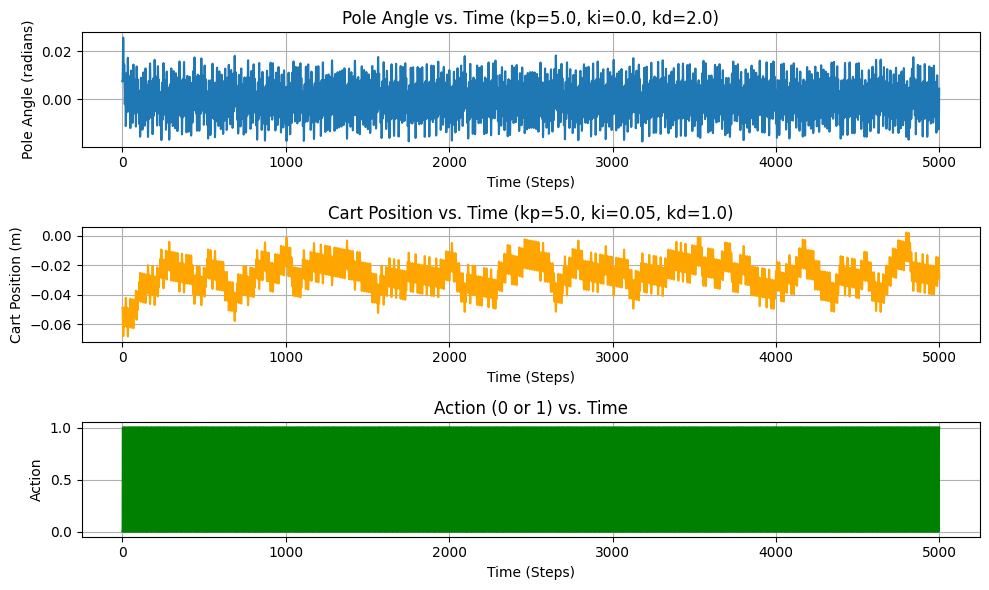

In [103]:
import gymnasium as gym
import math
import matplotlib.pyplot as plt

# Create the environment
env = gym.make("CartPole-v1", render_mode="human", max_episode_steps=10000)
delta_t = env.get_wrapper_attr("tau")

# Set your unique student ID number (last 2 digits)
YOUR_INDEX_NUMBER = 13  # Replace with your own number
env.set_wrapper_attr("theta_threshold_radians", 90 * 2 * math.pi / 360)
env.set_wrapper_attr("length", 0.5 + (YOUR_INDEX_NUMBER) / 99)

# Pole
kp_1=5.0
ki_1=0.0
kd_1=2.0

# Cart
kp_2=5.0
ki_2=0.05
kd_2=1.0
# Create PID controllers for cart and pole (assuming PID class is defined)
cart_controller = PID(kp=kp_1, ki=ki_1, kd=kd_1, dt=delta_t, goal=0.0)
pole_controller = PID(kp=kp_2, ki=ki_2, kd=kd_2, dt=delta_t, goal=0.0)

# Initialize the environment and observation
observation, info = env.reset()

# Initialize lists to store data for plotting
pole_angles = []
cart_positions = []
actions = []
times = []

step_count = 0

while step_count < 5000:
    try:
        cart_position = observation[0]
        pole_angle = observation[2]

        # Get controller outputs
        cart_output = cart_controller.get_output(cart_position)
        pole_output = pole_controller.get_output(pole_angle)

        # Combine the controller outputs for the final control action
        control_output = 0.1 * cart_output + pole_output
        action = 1 if control_output < 0 else 0  # Convert control output to action (0 or 1)

        # Store the data for plotting
        pole_angles.append(pole_angle)
        cart_positions.append(cart_position)
        actions.append(action)
        times.append(step_count)
        step_count += 1

        # Apply action to the environment
        observation, reward, terminated, truncated, info = env.step(action)

        # Check if the episode is terminated or truncated
        if terminated or truncated:
            print(f"terminated {terminated}, truncated: {truncated}")
            observation, info = env.reset()

    except KeyboardInterrupt:
        break

# Close the environment when done
env.close()

# After the simulation, plot the results
plt.figure(figsize=(10, 6))
# Plot the pole angle
plt.subplot(3, 1, 1)
plt.plot(times, pole_angles, label='Pole Angle (θ)')
plt.xlabel('Time (Steps)')
plt.ylabel('Pole Angle (radians)')
plt.title(f"Pole Angle vs. Time (kp={kp_1}, ki={ki_1}, kd={kd_1})")
plt.grid(True)

# Plot the cart position
plt.subplot(3, 1, 2)
plt.plot(times, cart_positions, label='Cart Position (x)', color='orange')
plt.xlabel('Time (Steps)')
plt.ylabel('Cart Position (m)')
plt.title(f"Cart Position vs. Time (kp={kp_2}, ki={ki_2}, kd={kd_2})")
plt.grid(True)

# Plot the action taken (0 or 1)
plt.subplot(3, 1, 3)
plt.plot(times, actions, label='Action (0 or 1)', color='green')
plt.xlabel('Time (Steps)')
plt.ylabel('Action')
plt.title('Action (0 or 1) vs. Time')
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("step_6.1.png", dpi=300, bbox_inches='tight') 
plt.show()


# Acknowledgements

Prepared by Mr. Ignatious Peiris on the 30th of April 2025.

Adapted from [Learn to PID the Cart-Pole in the OpenAI Gym](https://statusfailed.com/blog/2022-12-08-pid-controller-in-the-openai-gym/). 

## Step 2: PID Tuning Process

### Step 1
In the first step, only the proportional gain (kp) was applied to both the pole and the cart. A value of kp = 5.0 was chosen.

Pole - kp_1=5.0, ki_1=0.0, kd_1=0.0

Cart - kp_2=5.0, ki_2=0.0, kd_2=0.0

With only proportional control, the system was highly reactive but underdamped. The pole showed significant oscillations around the upright position, and the cart moved aggressively to correct these deviations. There was no damping or error accumulation management, making the system unstable in the long run.

![Step 1](step_1.jpg)

### Step 2
To address the oscillations observed in Step 1, a derivative gain (kd) of 1.0 was added to both controllers.
The addition of derivative control helped dampen rapid fluctuations by reacting to the rate of change of error. This reduced the amplitude of oscillations, improving stability. However, slight residual oscillations still persisted.

Pole - kp_1=5.0, ki_1=0.0, kd_1=1.0

Cart, kp_2=5.0, ki_2=0.0, kd_2=1.0


![Step 2](step_2.jpg)

### Step 3
In an attempt to further reduce oscillations, the derivative gain was increased from 1.0 to 2.0 for both controllers.
However, this change led to an undesirable side effect: although pole oscillations did not improve significantly, the cart began drifting away from the center. This suggested that the higher derivative gain may have started counteracting the control too aggressively, especially for the cart dynamics.

Pole - kp_1=5.0, ki_1=0.0, kd_1=2.0

Cart - kp_2=5.0, ki_2=0.0, kd_2=2.0


![Step 3](step_3.jpg)

### Step 4
To fix the cart drift observed in Step 3, the derivative gain for the cart was reduced back to 1.0, while keeping the pole's kd at 2.0.
This change helped stabilize the cart movement, while still providing extra damping for the pole. The overall control response became more balanced, and the cart was better at staying near the center while keeping the pole upright.

Pole - kp_1=5.0, ki_1=0.0, kd_1=2.0

Cart - kp_2=5.0, ki_2=0.0, kd_2=1.0


![Step 4](step_4.jpg)


### Step 5 
To test the robustness of the tuning, the simulation was allowed to run for a longer duration. The system initially exhibited larger oscillations in the cart’s position, but those gradually reduced over time. This indicated that the current controller gains were providing semi-stable behavior, but improvements were still needed for faster convergence and less overshoot.

![Step 5](step_5.jpg)

### Step 6
To reduce initial overshoot and help the cart settle closer to the goal position, a small integral gain (ki) of 0.05 was introduced to the cart controller.
The integral component allowed the controller to account for accumulated error over time, reducing the steady-state error that was causing the cart to drift slightly from the center. This significantly improved the controller’s ability to maintain the cart's position after correcting for initial disturbances.

Cart - kp_2=5.0, ki_2=0.05, kd_2=1.0

![Step 6](step_6.jpg)

## Final Values

Pole

* kp_1=5.0

* ki_1=0.0

* kd_1=2.0

Cart

* kp_2=5.0

* ki_2=0.05

* kd_2=1.0

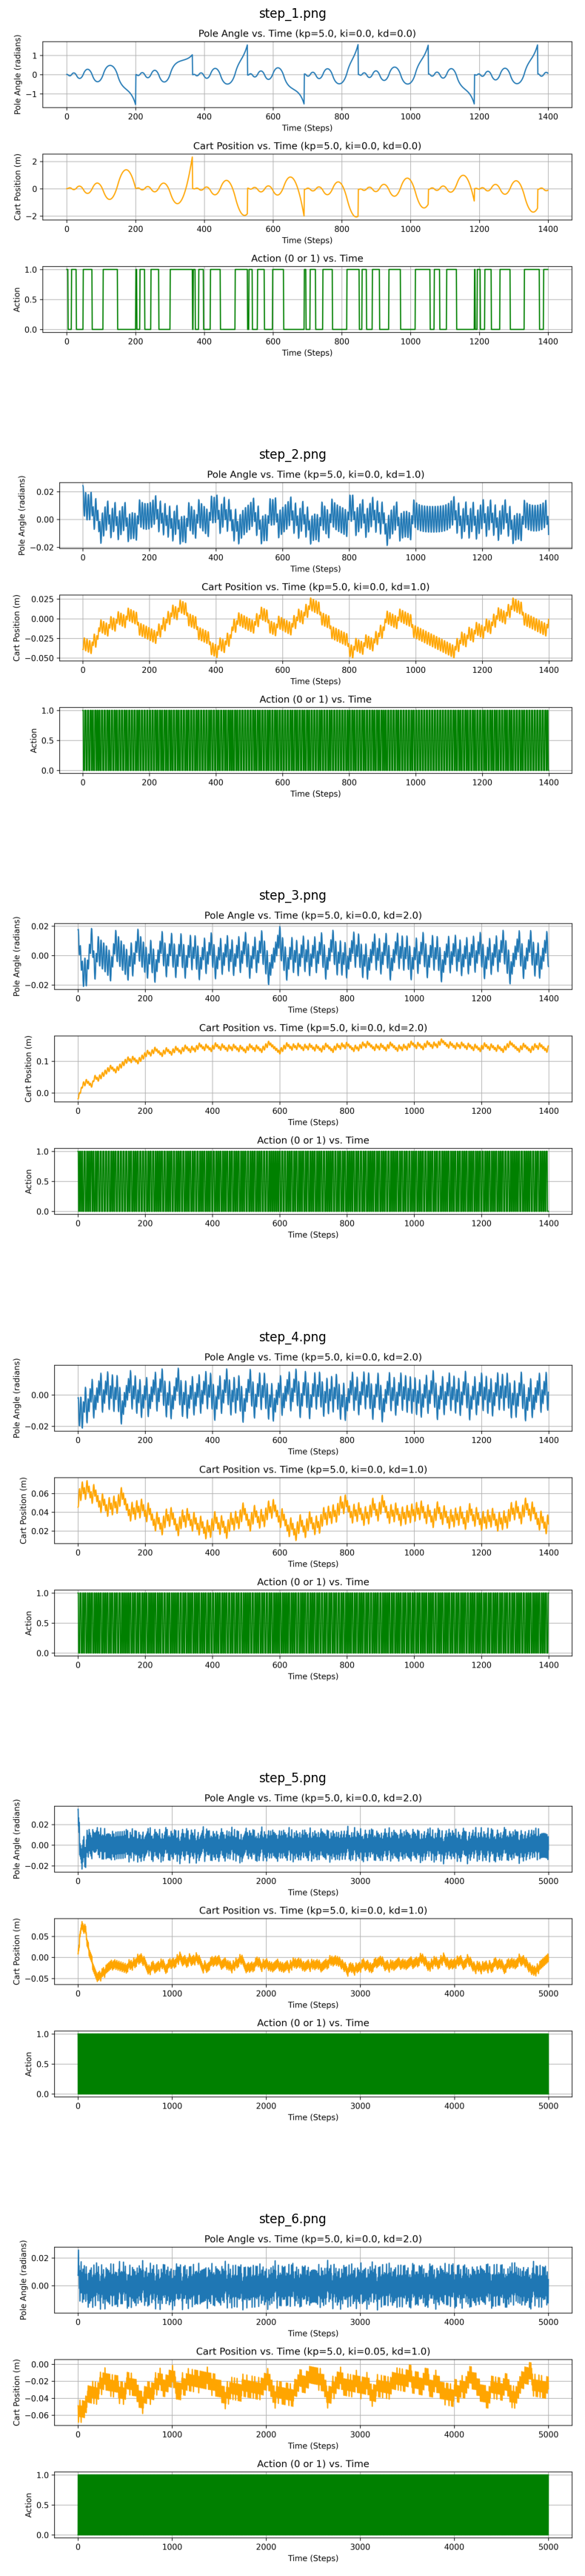

In [105]:
import cv2
import os
import matplotlib.pyplot as plt

def display_images_from_directory(directory=".", image_names=None):
    files = os.listdir(directory)
    image_files = [f for f in files if f.lower().endswith(('.jpg', '.png', '.jpeg', '.gif'))]
    if image_names:
        image_files = [f for f in image_files if f in image_names]
        image_files.sort()
    else:
        image_files.sort()
    if not image_files:
        print(f"No image files found in the directory: {directory}")
        return
    fig, axes = plt.subplots(len(image_files), 1, figsize=(8, 6 * len(image_files)))
    if len(image_files) == 1:
        axes = [axes]
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(directory, image_file)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error reading image: {image_path}")
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        axes[i].set_title(image_file) 
        axes[i].axis('off') 
    plt.tight_layout()
    plt.show()

image_names_to_display = [f"step_{i}.png" for i in range(1, 7)]
display_images_from_directory(image_names=image_names_to_display)


## Step 3: What are the limitations of your PID controller and the CartPole system itself? Consider the following points in your answer:

### The force applied to the cart is limited ±10.0 in Gym environment. How does this limit the controller's ability to correct large/fast disturbances?

±10.0 force limits the controller's ability to quickly correct large/fast disturbances, potentially leading to slower recovery or failure to balance.

### Can the controller keep the cart within typical position limits (e.g., -2.4 to +2.4)? Does it try to apply unrealistic forces if the angle gets too large?

The controller tries to keep the cart within limits but might demand unrealistic forces for large angles, which are then clipped by the environment.

### Is the PID structure itself sufficient? Are there situations (e.g., very large disturbances) where it fundamentally fails?

PID might fail for very large disturbances due to the system's non-linearity and the controller's linear nature, especially with binary actuation.

### What would happen to the system if the integrator term was left to increase indefinitely, as it currently does?

Unchecked integrator growth leads to overshoot, oscillations, slow recovery, and potential instability due to accumulated error during saturation.